# Amplitude Estimation


Amplitude estimation, in the simplest case, where we have an unknown Bernoulli Random Variable - and we want to estimate its success probability $p$. 

We assume that a qubit is prepared in a state $\sqrt{1-p}\,\big|0\rangle + \sqrt{p}\,\big|1\rangle$, i.e., the probability of measuring $\big|1\rangle$ equals $p$.
<br>
<br>
Amplitude estimation uses two operators: <br>
1) $A$ - describes the problem as, $$A = R_y(\theta_p)$$ i.e., it equals a rotation with an angle $\theta_p = 2\sin^{-1}(\sqrt{p})$ around the Y-axis.<br>
2) $Q$ - is derived from $A$. For this single qubit case, $Q$ is represented by a Y-rotation of twice $\theta_p$, i.e., $$Q = R_y(2\theta_p)$$

This particularly implies that powers of the operator can be efficiently represented, i.e. $Q^k = R_y(2k\theta_p)$.
The result is then mapped into $m$ evaluation qubits. The larger $m$, the higher the accuracy of the estimation but also the longer the quantum circuit.

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.tools.visualization import plot_bloch_vector
from qiskit import BasicAer
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua.utils import CircuitFactory
#from qiskit.aqua.algorithms.single_sample.amplitude_estimation.q_factory import QFactory
from qiskit.aqua.components.uncertainty_problems import UncertaintyProblem
#from qiskit.aqua.circuits.gates import cry
#from qiskit.circuit.library import CRYGate

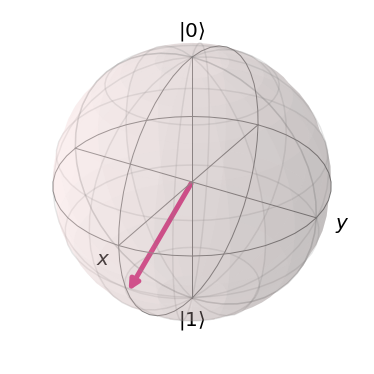

In [39]:
# the probability to be recovered
probability = 0.72
theta_p = 2*np.arcsin(np.sqrt(probability))

# the resulting quantum state after A is applied
plot_bloch_vector([np.sin(theta_p), 0.0, np.cos(theta_p)])

In [40]:
class BernoulliAFactory(UncertaintyProblem):
    """
    Circuit Factory representing the operator A.
    A is used to initialize the state as well as to construct Q.
    """
    
    def __init__(self, probability=0.5):
        # 
        super().__init__(1)
        self._probability = probability
        self.i_state = 0
        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
    
    def build(self, qc, q, q_ancillas=None):
        
        # A is a rotation of angle theta_p around the Y-axis
        qc.ry(self._theta_p, q[self.i_state])


class BernoulliQFactory(CircuitFactory):
    """
    Circuit Factory representing the operator Q.
    This implementation exploits the fact that powers of Q can be implemented efficiently by just multiplying the angle.
    (amplitude estimation only requires controlled powers of Q, thus, only this method is overridden.)
    """
    
    def __init__(self, bernoulli_expected_value):
        super().__init__(bernoulli_expected_value.num_target_qubits)#, i_objective=0)
        self.a_factory=bernoulli_expected_value
    
    def build(self, qc, q, q_ancillas=None):
        i_state = self.a_factory.i_state
        theta_p = self.a_factory._theta_p
        # Q is a rotation of angle 2*theta_p around the Y-axis
        qc.ry(q[i_state], 2*theta_p)
    
    def build_controlled_power(self, qc, q, q_control, power, q_ancillas=None, use_basis_gates=True):
        i_state = self.a_factory.i_state
        theta_p = self.a_factory._theta_p
        qc.cry(2*power*theta_p, q_control, q[i_state])

In [45]:
# construct factories for A and Q
bernoulli_a_factory = BernoulliAFactory(probability)
print (bernoulli_a_factory)
print (bernoulli_a_factory.num_target_qubits)
bernoulli_q_factory = BernoulliQFactory(bernoulli_a_factory)

# set number of evaluation qubits
# with more ancilla qubits - the estimation is more accurate
#m = 1
m = 5

# construct amplitude estimation
# here, we override the standard construction of Q since we know a more efficient way
# (exploiting the fact that A and Q are just Y-rotations)
ae = AmplitudeEstimation(m, bernoulli_a_factory, q_factory=bernoulli_q_factory)

1


In [46]:
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'))
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))

In [47]:
print(result)

{'statevector': array([[-0.01664467+5.25725102e-18j, -0.04215897+8.38185229e-18j,
        -0.00040829-5.40651659e-02j, -0.00040829+5.40651659e-02j,
        -0.01482057-1.46639635e-02j, -0.06230274-6.29753087e-02j,
        -0.06230274+6.29753087e-02j, -0.01482057+1.46639635e-02j,
        -0.01624595-6.67473249e-03j, -0.04504886-1.88136311e-02j,
         0.15569465-3.83447038e-01j, -0.01128402+2.67148544e-02j,
        -0.01128402-2.67148544e-02j,  0.15569465+3.83447038e-01j,
        -0.04504886+1.88136311e-02j, -0.01624595+6.67473249e-03j,
        -0.01654805-3.26646112e-03j, -0.04281169-8.58185317e-03j,
         0.01821607-9.52660610e-02j, -0.0075904 +3.67374207e-02j,
        -0.01345553-1.98675674e-02j, -0.11280267-1.71147520e-01j,
        -0.05006751+3.37606756e-02j, -0.01569775+1.03944903e-02j,
        -0.01569775-1.03944903e-02j, -0.05006751-3.37606756e-02j,
        -0.11280267+1.71147520e-01j, -0.01345553+1.98675674e-02j,
        -0.0075904 -3.67374207e-02j,  0.01821607+9.52660610e

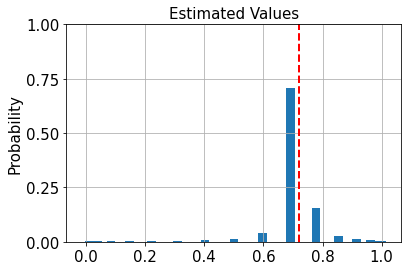

In [48]:
# plot estimated values
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

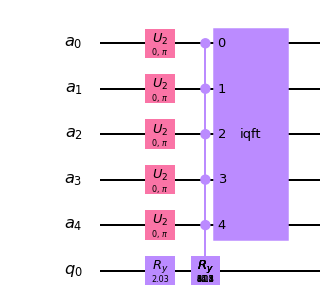

In [49]:
# plot circuit
ae._circuit.draw(output='mpl')

## References
<br>
<br>
[1] <a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>
<br>
[2] <a href="https://arxiv.org/abs/quant-ph/0005055">Quantum Amplitude Amplification and Estimation. Brassard et al. 2000.</a>